![example](images/director_shot.jpeg)

# Microsoft Box Office Insights

**Author:** Jeffrey Hanif Watson
***

## Overview

This project provides a broad overview of the contemporary film industry as well as recommendations with regards to the probable initial capital requirements and film genres that will offer a high probability to maximize profit and return on investment. Descriptive analysis is performed on data obtained from the [The Numbers](https://www.the-numbers.com/), [Rotten Tomatoes](https://www.rottentomatoes.com/), and the [IMDb](https://www.imdb.com/) to arrive at these conclusions. 

## Business Problem

Microsoft is looking to enter the film industry and requires an overview of the market along with data analysis to help drive decisions. Variables highlighted for analysis include production cost, gross profit, net profit, return on investment, and the ratio of domestic to foreign box office receipts.

## Data Understanding

Data aggregated from [Rotten Tomatoes](https://www.rottentomatoes.com/) provides a solid foundation to analyze overall box office trends, genre trends, and individual film titles. [IMDb](https://www.imdb.com/) data is better formatted to research actors, directors, writers and, producers. Numerical data from [The Numbers](https://www.the-numbers.com/) is joined with the datasets above to facilitate quantitative analysis on both.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

%matplotlib inline

# update cpi if flagged out of date
# cpi.update()

In [2]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query function
def fetcha(q):
    return cur.execute(q).fetchall()

In [3]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

## Data Preparation

We will create two data frames using SQLite to join tables from our database and perform exploratory data analysis and data cleaning. Non-numeric NaNs will be converted to strings, date strings will be changed to datetime objects, and numeric strings will be converted to floats. Features such as international gross, return on investment (ROI), gross adjusted for inflation will as needed to facilitate analysis.

# Rotten Tomatoes DF

In [4]:
# getting the columns from the rotten tomatoes table
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [5]:
# getting the columns from the numbers table
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [6]:
# creating dataframe by joining the numbers and rotten tomatoes tables 
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       """
dfr = pd.DataFrame(fetcha(q))
dfr.columns = [i[0] for i in cur.description]
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

# Data Cleaning

In [7]:
# checking for NaN values
dfr.isna().sum()

idx                                   0
rotten_tomatoes_link                  0
movie_title                           0
movie_info                           35
critics_consensus                   642
content_rating                        0
genres                                0
directors                            52
authors                             119
actors                               14
original_release_date                64
streaming_release_date               38
runtime                              35
production_company                   17
tomatometer_status                    3
tomatometer_rating                    3
tomatometer_count                     3
audience_status                      31
audience_rating                      12
audience_count                       13
tomatometer_top_critics_count         0
tomatometer_fresh_critics_count       0
tomatometer_rotten_critics_count      0
idx                                   0
id                                    0


In [8]:
# changing name NaNs to strings
dfr['actors'] = dfr['actors'].fillna('NaN')
dfr['directors'] = dfr['directors'].fillna('NaN')
dfr['authors'] = dfr['authors'].fillna('NaN')
dfr['production_company'] = dfr['production_company'].fillna('NaN')

# change date strings to datetime objects 
dfr.release_date = pd.to_datetime(dfr.release_date)
dfr['year'] = dfr['release_date'].apply(lambda x: x.year)
dfr['month'] = dfr['release_date'].apply(lambda x: x.month)

#cleaning numerical strings and converting to floats
dfr['worldwide_gross'] = dfr['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['domestic_gross'] = dfr['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['production_budget'] = dfr['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [9]:
# adding intl gross and % international column
dfr['international_gross'] = dfr['worldwide_gross'].sub(dfr['domestic_gross'])
dfr['percent_intl'] = (dfr['international_gross'].divide(dfr['worldwide_gross']))*100

In [10]:
# adding net profit columns
dfr['domestic_net'] = dfr['domestic_gross'].sub(dfr['production_budget'])
dfr['worldwide_net'] = dfr['worldwide_gross'].sub(dfr['production_budget'])
dfr['international_net'] = dfr['international_gross'].sub(dfr['production_budget'])

In [11]:
# adding roi columns
dfr['domestic_roi'] = dfr['domestic_net'].divide(dfr['production_budget'])*100
dfr['worldwide_roi'] = dfr['worldwide_net'].divide(dfr['production_budget'])*100
dfr['international_roi'] = dfr['international_net'].divide(dfr['production_budget'])*100

In [12]:
dfr#adding adjust gross profit and budget columns
dfr['adj_dom_gross'] = dfr.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
dfr['adj_ww_gross'] = dfr.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
dfr['adj_i_gross'] = dfr.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
dfr['adj_prod_budg'] = dfr.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)

In [13]:
#adding net profit columns
dfr['adj_dom_net'] = dfr['adj_dom_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_ww_net'] = dfr['adj_ww_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_i_net'] = dfr['adj_i_gross'].sub(dfr['adj_prod_budg'])

In [14]:
dfr['adj_percent_intl'] = (dfr['adj_i_gross'].divide(dfr['adj_ww_gross']))*100

In [15]:
#checking results
dfr.head(1)

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,worldwide_roi,international_roi,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_percent_intl
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,134.790394,41.350075,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07,60.202665


In [16]:
# checking column names
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'percent_intl', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_percent_intl'],
      dtype='object')

In [17]:
# renaming columns and checking
dfr = dfr.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'percent_intl', 'domestic_net',
       'worldwide_net', 'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_percent_intl'],
      dtype='object')

In [18]:
# creating rt genre list
split_list = []
for genre in dfr.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))

In [19]:
# creating function to count genres

def genre_count(DF, genre_list):
    """a function that accepts a data frame and list of genres
    and returns a list consisting of a genre list and a list of counts"""
    counts = []
    for genre in genre_list:
        count = DF.genres.str.contains(genre, case=False).sum()
        counts.append(count)
    return ([genre_list, counts])

# IMDb DF

In [20]:
# creating talent dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
dfi = pd.DataFrame(fetcha(q))
dfi.columns = [i[0] for i in cur.description]   

In [21]:
# checking columns and dtypes
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [22]:
# renaming columns and dropping extraneous columns
dfi = dfi.drop(['idx', 'birth_year', 'death_year', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
dfi = dfi.rename(columns = {'movie':'title', 'release_date':'date'})

In [23]:
# checking numbers of NaNs
dfi.isna().sum()

nconst                 0
primary_name           0
tconst                 0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [24]:
# changings NaNs to strings
dfi['genres'] = dfi.genres.fillna('NaN')

#cleaning numerical strings and converting to floats
dfi['worldwide_gross'] = dfi['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['domestic_gross'] = dfi['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['production_budget'] = dfi['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

# change date string to datetime object 
dfi.date = pd.to_datetime(dfi.date)
dfi['year'] = dfi['date'].apply(lambda x: x.year)
dfi['month'] = dfi['date'].apply(lambda x: x.month)

In [25]:
# defining function to adjust for inflation because the year
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    """accepts a row and a column name and checks
    if the year of the row is 2020. If the year is not 2020,
    a value adjusted for inflation is returned. If the year is 2020,
    the original value is returned"""
    
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

In [26]:
# creating intl gross column
dfi['international_gross'] = dfi['worldwide_gross'].sub(dfi['domestic_gross'])

#adding adjusted budget and gross profit columns
dfi['adj_prod_budg'] = dfi.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
dfi['adj_dom_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
dfi['adj_ww_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
dfi['adj_i_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

#adding net profit columns
dfi['adj_dom_net'] = dfi['adj_dom_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_ww_net'] = dfi['adj_ww_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_i_net'] = dfi['adj_i_gross'].sub(dfi['adj_prod_budg'])

#adding return on investment columns and checking results
dfi['dom_roi'] = dfi['adj_dom_net'].divide(dfi['adj_prod_budg'])
dfi['ww_roi'] = dfi['adj_ww_net'].divide(dfi['adj_prod_budg'])
dfi['i_roi'] = dfi['adj_i_net'].divide(dfi['adj_prod_budg'])
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,dom_roi,ww_roi,i_roi
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,...,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08,-1.562365e+07,1.434927e+08,9.653712e+07,-0.249662,2.292976,1.542638


In [27]:
# getting job titles
dfi.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

In [28]:
# creating imdb genres list
split_list = []
for genre in dfi.genres:
    split_list += [g.strip() for g in genre.split(',')]
genres_i = list(set(split_list))

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [29]:
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='winter_r')

# Top 100 Films by Worldwide Gross

In [30]:
# creating dataframes sorted by gross
title_gross = dfr[['title', 'production_budget', 'domestic_gross', 'worldwide_gross',\
                   'international_gross', 'worldwide_net', 'worldwide_roi',\
                   'percent_intl', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top20_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(20)

#  getting count by year
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})

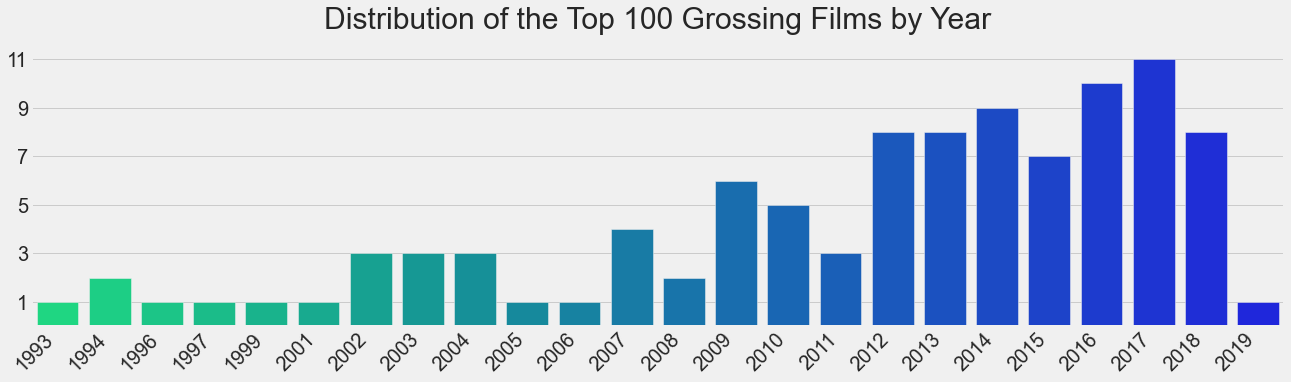

In [31]:
fig, ax= plt.subplots(figsize=(20,5))
ax = sns.barplot(x='year', y= 'count', data=t100_count_by_year, palette='winter_r')
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 12), yticks=[1, 3, 5, 7, 9, 11])
ax.tick_params(labelsize=20) 
ax.set_xlabel("", size = 20)
ax.set_ylabel("") 
ax.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 30 )
plt.show()

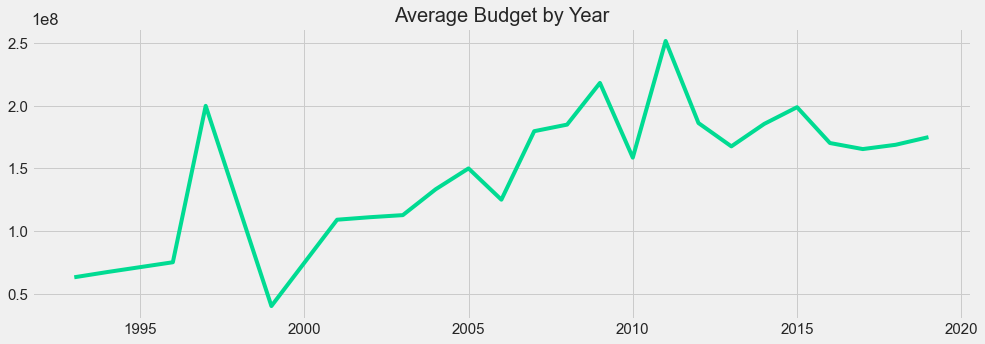

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ci=None)
ax.tick_params(labelsize=15) 
ax.set_xlabel("")
ax.set_ylabel("") 
ax.set_title( "Average Budget by Year", size=20)
plt.show()

In [33]:
medians = [top100_gross_films.production_budget.median(),\
          top100_gross_films.worldwide_gross.median(),\
          top100_gross_films.worldwide_net.median(),\
          top100_gross_films.worldwide_roi.median()]
medians

[172500000.0, 879423029.0, 700371985.5, 451.34287125]

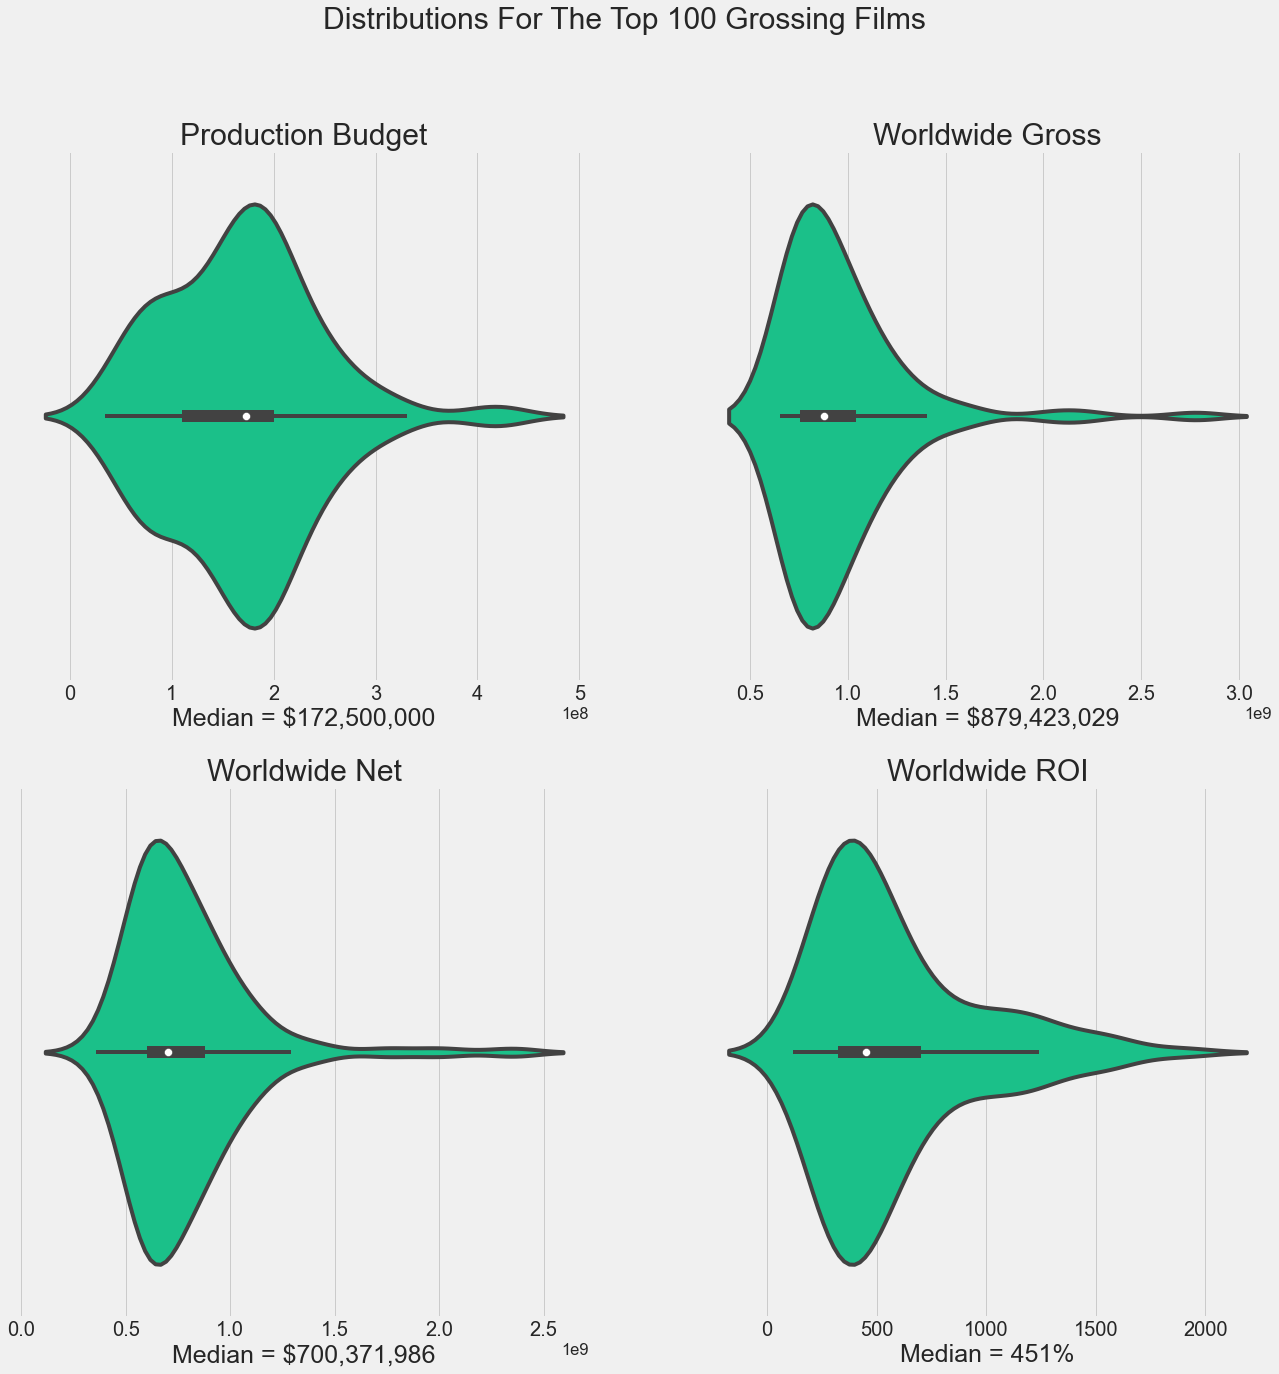

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
fig.suptitle('Distributions For The Top 100 Grossing Films', size=30)
sns.violinplot(ax=axes[0, 0], x='production_budget', data=top100_gross_films,)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=top100_gross_films)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=top100_gross_films)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=top100_gross_films)
axes[0,0].set_title('Production Budget', size = 30)
axes[0,1].set_title('Worldwide Gross', size = 30)
axes[1,0].set_title('Worldwide Net', size = 30)
axes[1,1].set_title('Worldwide ROI', size = 30)
axes[0,0].set_xlabel('Median = $172,500,000', size=25)
axes[0,1].set_xlabel('Median = $879,423,029', size=25)
axes[1,0].set_xlabel('Median = $700,371,986', size=25)
axes[1,1].set_xlabel('Median = 451%', size=25)
axes[0,0].tick_params(axis="x", labelsize=20)
axes[0,1].tick_params(axis="x", labelsize=20)
axes[1,0].tick_params(axis="x", labelsize=20)
axes[1,1].tick_params(axis="x", labelsize=20)
plt.show()

In [35]:
# top 100 by gross basic stats
top100_gross_films.describe()

,production_budget,domestic_gross,worldwide_gross,international_gross,worldwide_net,worldwide_roi,percent_intl,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,1.685750e+08,3.409426e+08,9.576570e+08,6.167144e+08,7.890820e+08,584.638778,63.944459,2011.340000,7.250000
std,7.397127e+07,1.230460e+08,3.273300e+08,2.479270e+08,3.019174e+08,368.824404,8.550096,6.067333,2.903759
min,3.500000e+07,1.595559e+08,6.522201e+08,2.699127e+08,3.559452e+08,118.648403,39.814630,1993.000000,2.000000
25%,1.100000e+08,2.575551e+08,7.578371e+08,4.667287e+08,6.014434e+08,323.640428,58.218483,2009.000000,5.000000
50%,1.725000e+08,3.236558e+08,8.794230e+08,5.530922e+08,7.003720e+08,451.342871,64.049093,2013.000000,6.000000
75%,2.000000e+08,4.025105e+08,1.040525e+09,6.906684e+08,8.783895e+08,702.984598,70.182428,2016.000000,11.000000
max,4.250000e+08,7.605076e+08,2.776345e+09,2.015838e+09,2.351345e+09,1892.737054,81.717176,2019.000000,12.000000


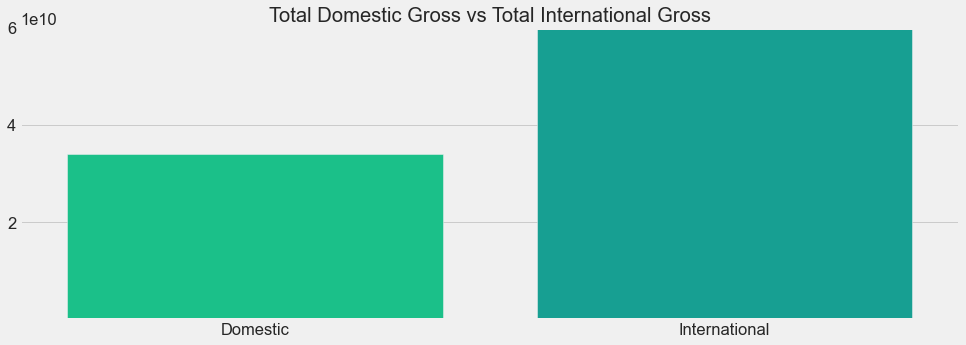

In [36]:
dom = top100_gross_films.domestic_gross.sum()
intl = top100_gross_films.international_gross.sum()
dvsi = pd.DataFrame({'type': ['Domestic', 'International'], 'values': [dom, intl]})
fig, ax=plt.subplots(figsize=(15,5))
ax = sns.barplot(x='type', y='values', data=dvsi)
ax.set(ylim=[0, 1*10**10], yticks=[2*10**10, 4*10**10, 6*10**10])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Total Domestic Gross vs Total International Gross")
plt.show()

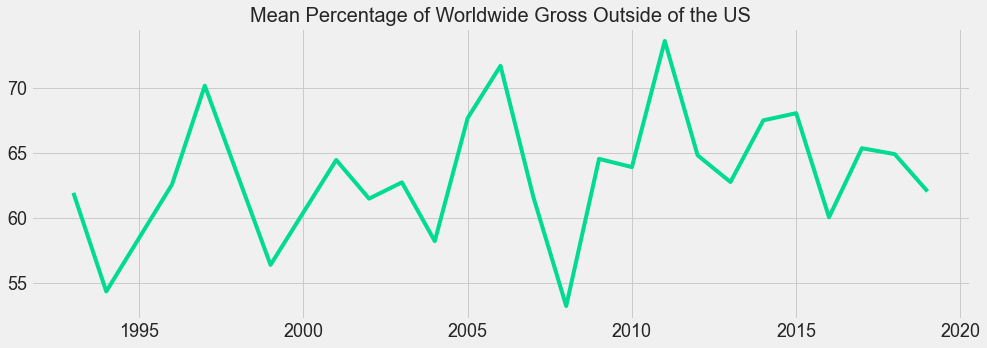

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x='year', y='percent_intl', data=top100_gross_films, ci=None)
ax.tick_params(labelsize=18) 
ax.set_xlabel("")
ax.set_ylabel("") 
ax.set_title( "Mean Percentage of Worldwide Gross Outside of the US", size=20)
plt.show()

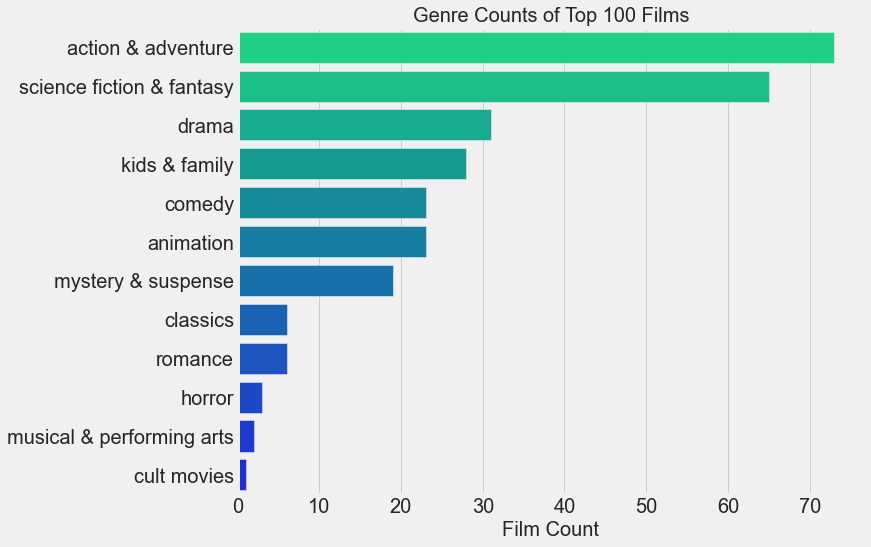

In [38]:
# top gross genres; there are overlaps because a film can have multiple genres
gross_genres = genre_count(top100_gross_films, genres)
top_g_genres = pd.DataFrame()
top_g_genres['Genre'] = gross_genres[0]
top_g_genres['Count'] = gross_genres[1]
top_g_genres = top_g_genres.sort_values(by='Count', ascending=False).head(12)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_g_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20)
ax.set_ylabel("")
ax.set_title("Genre Counts of Top 100 Films", fontsize=20)
plt.show()

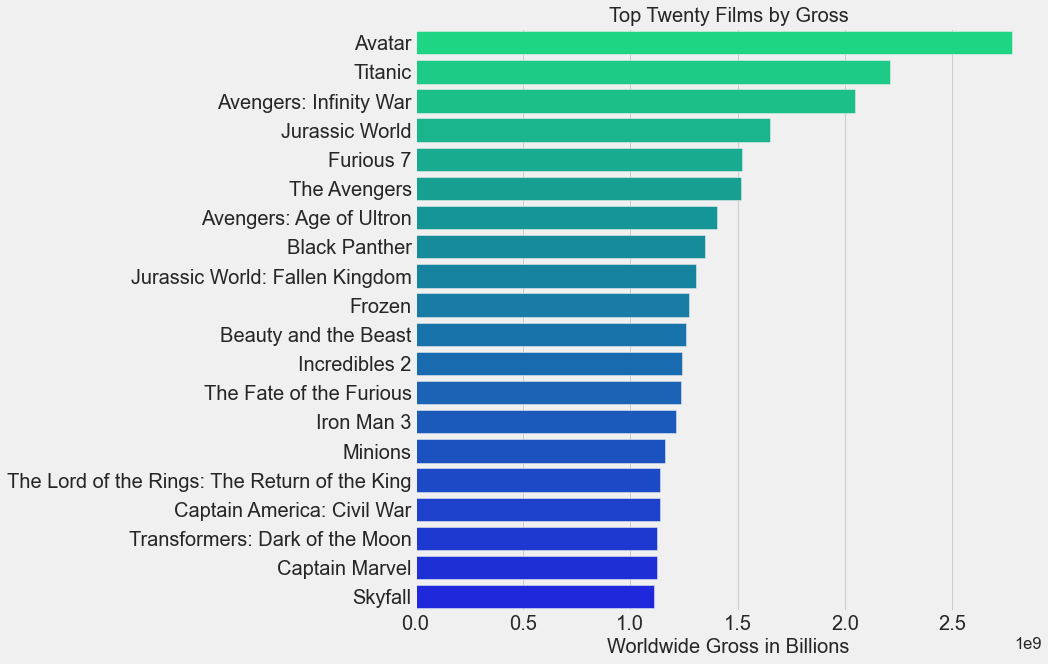

In [39]:
# plotting top 20 films by gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_gross', y='title', data= top20_gross_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Worldwide Gross in Billions", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Gross', size = 20)
plt.show()

# Top ROI Genres & Films

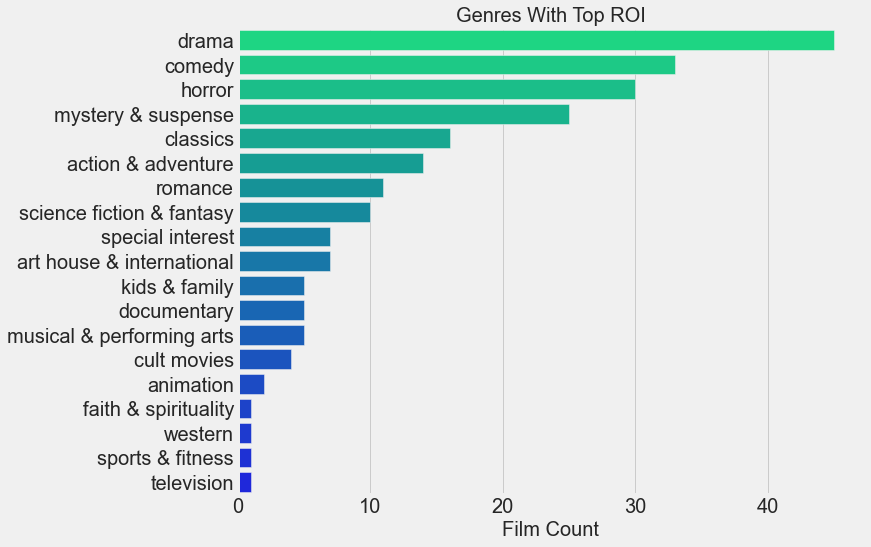

In [40]:
title_roi = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_titles = title_roi.drop_duplicates(subset = ['title'])
top20_roi_films = unique_titles.sort_values(by='worldwide_roi', ascending=False).head(20)
top100_roi_films = unique_titles.sort_values(by='worldwide_roi', ascending=False).head(100)

# top ROI genres; there are overlaps because a film can have multiple genres
roi_genres = genre_count(top100_roi_films, genres)
top_r_genres = pd.DataFrame()
top_r_genres['Genre'] = roi_genres[0]
top_r_genres['Count'] = roi_genres[1]
top_r_genres = top_r_genres.sort_values(by='Count', ascending=False).head(19)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_r_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genres With Top ROI", fontsize=20)
plt.show()

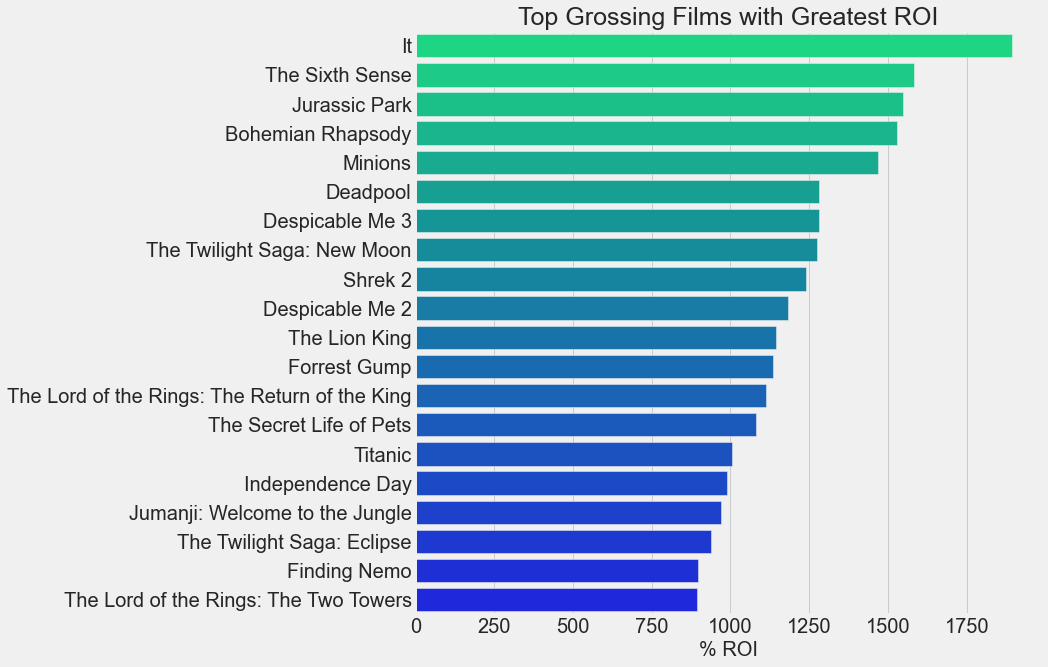

In [41]:
top20_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False).head(20)

# plotting top grossing film by ROI
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data=top20_gross_by_roi, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("% ROI", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Grossing Films with Greatest ROI', size = 25)
plt.show()

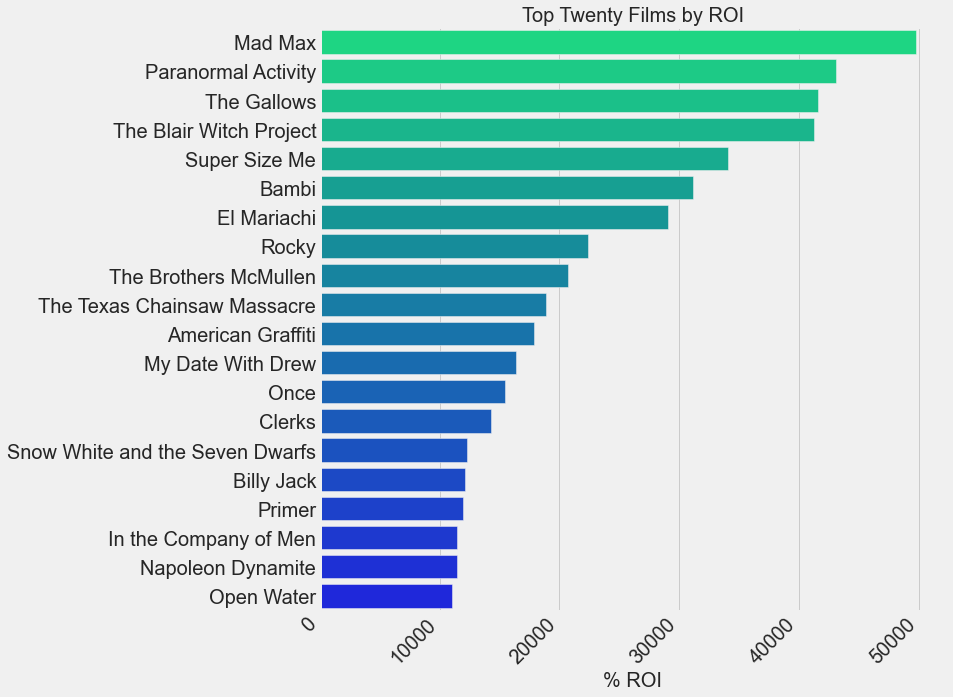

In [42]:
# plotting top 20 films by ROI
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data= top20_roi_films, palette='winter_r')
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set_xlabel("% ROI", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by ROI', size = 20)
plt.show()

# Genre Stats

## Top 5 Grossing Genres

In [43]:
action_df = dfr[dfr['genres'].str.contains('action & adventure', case=False)]
unique_titles_a = action_df.drop_duplicates(subset = ['title'])
top100_action = unique_titles_a.sort_values(by='worldwide_gross', ascending=False).head(100)
action = top100_action[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
action.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2011.500000,1.783150e+08,8.985821e+08,7.202671e+08,449.379772
std,5.732241,6.455350e+07,3.525110e+08,3.262740e+08,248.160289
min,1993.000000,5.800000e+07,5.610721e+08,3.559452e+08,118.648403
25%,2008.000000,1.380000e+08,6.550139e+08,5.012625e+08,299.426065
50%,2013.000000,1.725000e+08,8.017142e+08,6.307918e+08,374.943252
75%,2016.000000,2.000000e+08,1.017610e+09,8.292932e+08,523.124676
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,1548.908863


In [44]:
medians_action = [action.production_budget.median(),\
          action.worldwide_gross.median(),\
          action.worldwide_net.median(),\
          action.worldwide_roi.median()]
medians_action

[172500000.0, 801714223.0, 630791787.0, 374.94325196581195]

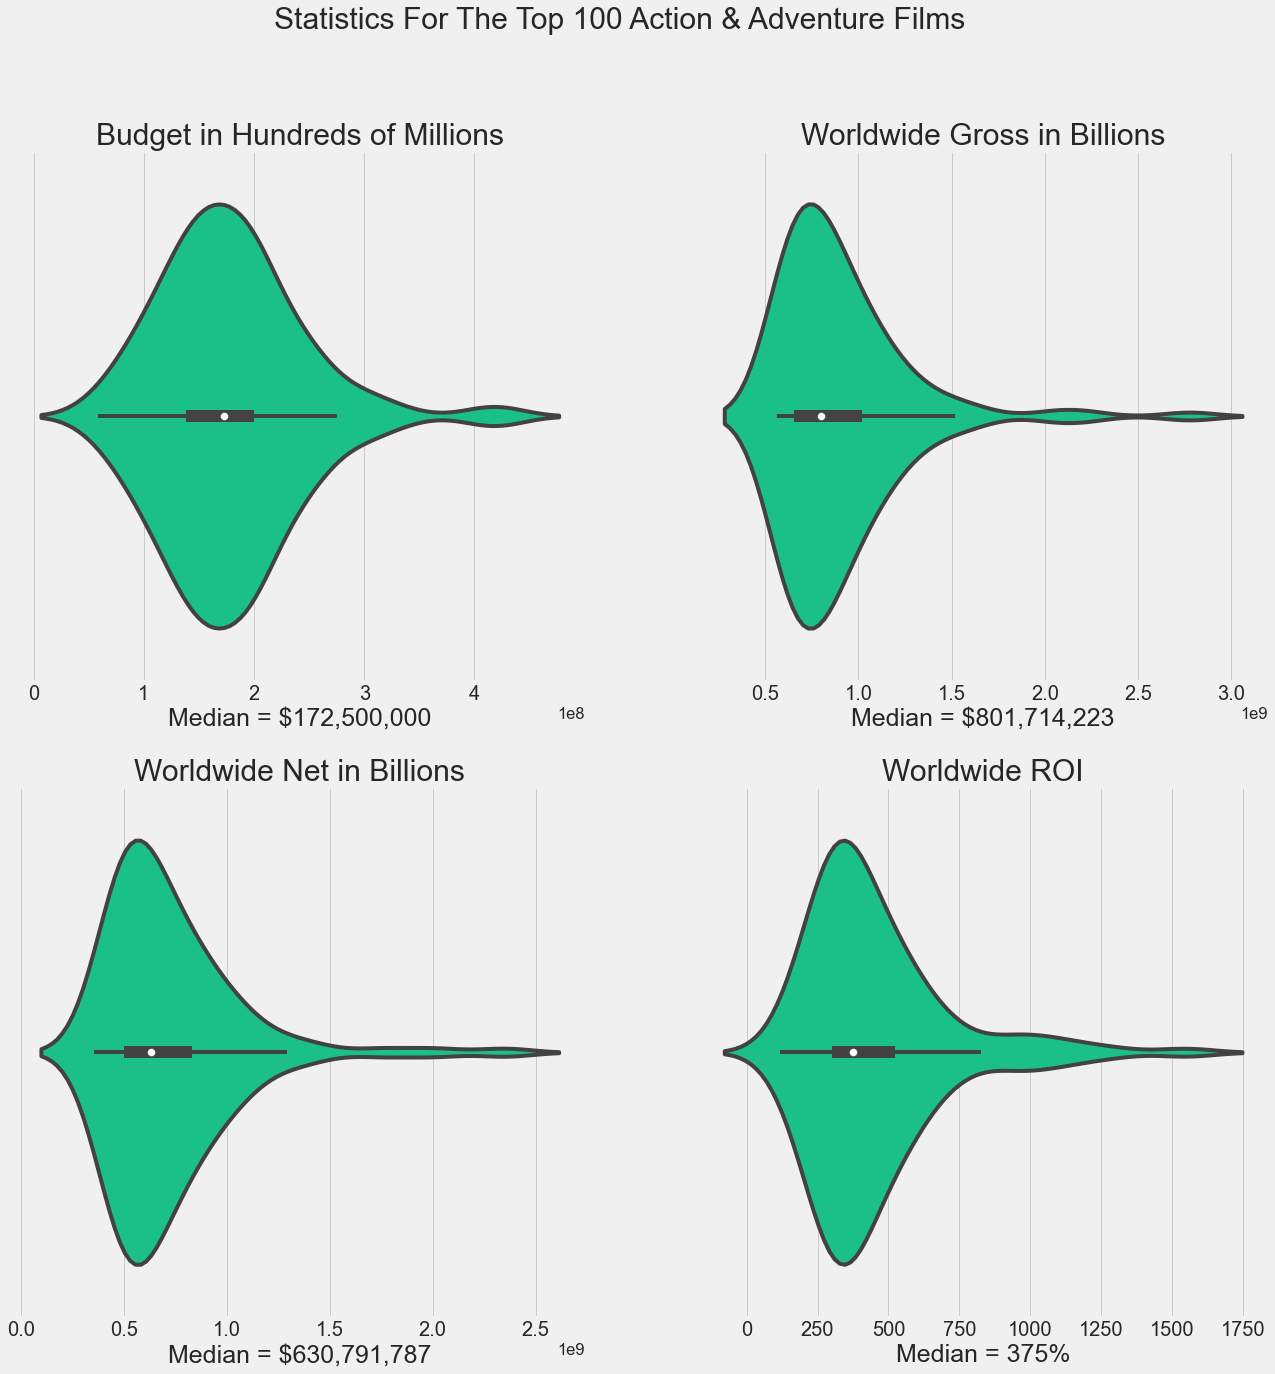

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=action)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=action)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=action)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=action)
fig.suptitle('Statistics For The Top 100 Action & Adventure Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $172,500,000', size=25)
axes[0, 1].set_xlabel('Median = $801,714,223', size=25)
axes[1, 0].set_xlabel('Median = $630,791,787', size=25)
axes[1, 1].set_xlabel('Median = 375%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [46]:
scifi_df = dfr[(dfr['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles_s = scifi_df.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles_s.sort_values(by='worldwide_gross', ascending=False).head(100)
scifi = top100_scifi[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
scifi.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2010.510000,1.658720e+08,8.159225e+08,6.500505e+08,475.676275
std,6.694631,6.833449e+07,3.287384e+08,2.985786e+08,345.671420
min,1990.000000,2.200000e+07,4.844686e+08,2.903591e+08,118.648403
25%,2007.000000,1.265000e+08,6.058507e+08,4.533670e+08,278.686918
50%,2013.000000,1.650000e+08,7.569612e+08,5.931777e+08,369.799577
75%,2016.000000,2.000000e+08,9.348282e+08,7.440441e+08,529.197018
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,2252.727273


In [47]:
medians_scifi = [scifi.production_budget.median(),\
          scifi.worldwide_gross.median(),\
          scifi.worldwide_net.median(),\
          scifi.worldwide_roi.median()]
medians_scifi

[165000000.0, 756961210.5, 593177671.5, 369.79957723325975]

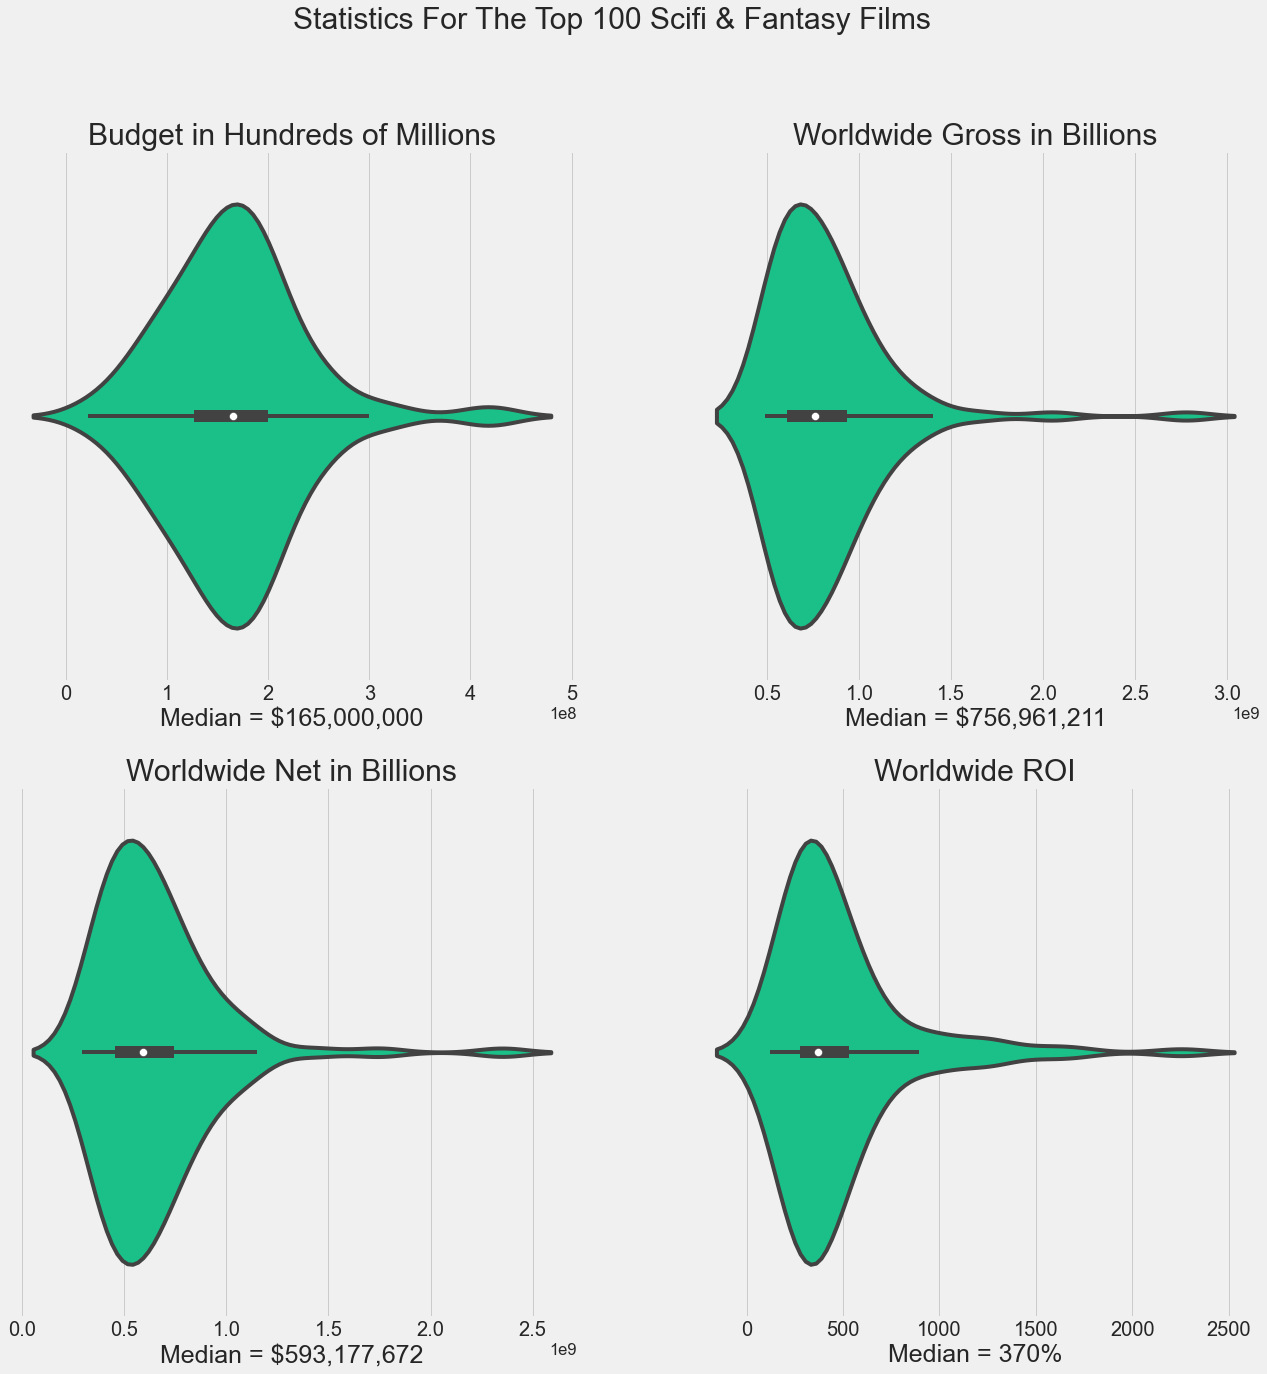

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=scifi)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=scifi)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=scifi)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=scifi)
fig.suptitle('Statistics For The Top 100 Scifi & Fantasy Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $165,000,000', size=25)
axes[0, 1].set_xlabel('Median = $756,961,211', size=25)
axes[1, 0].set_xlabel('Median = $593,177,672', size=25)
axes[1, 1].set_xlabel('Median = 370%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [49]:
drama_df = dfr[(dfr['genres'].str.contains('drama', case=False))]
unique_titles_d = drama_df.drop_duplicates(subset = ['title'])
top100_drama = unique_titles_d.sort_values(by='worldwide_gross', ascending=False).head(100)
drama = top100_drama[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
drama.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.00000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2008.40000,1.251080e+08,6.150942e+08,4.899862e+08,623.690578
std,8.96683,6.618245e+07,2.977274e+08,2.808384e+08,654.834085
min,1975.00000,1.200000e+07,3.510404e+08,1.181513e+08,42.964126
25%,2003.75000,7.982500e+07,4.096143e+08,3.129614e+08,232.416201
50%,2011.00000,1.250000e+08,4.906174e+08,3.958058e+08,405.283769
75%,2016.00000,1.662500e+08,7.599021e+08,6.389709e+08,682.499954
max,2018.00000,3.000000e+08,2.208208e+09,2.008208e+09,3822.500000


In [50]:
medians_drama = [drama.production_budget.median(),\
          drama.worldwide_gross.median(),\
          drama.worldwide_net.median(),\
          drama.worldwide_roi.median()]
medians_drama

[125000000.0, 490617448.5, 395805753.0, 405.28376869677413]

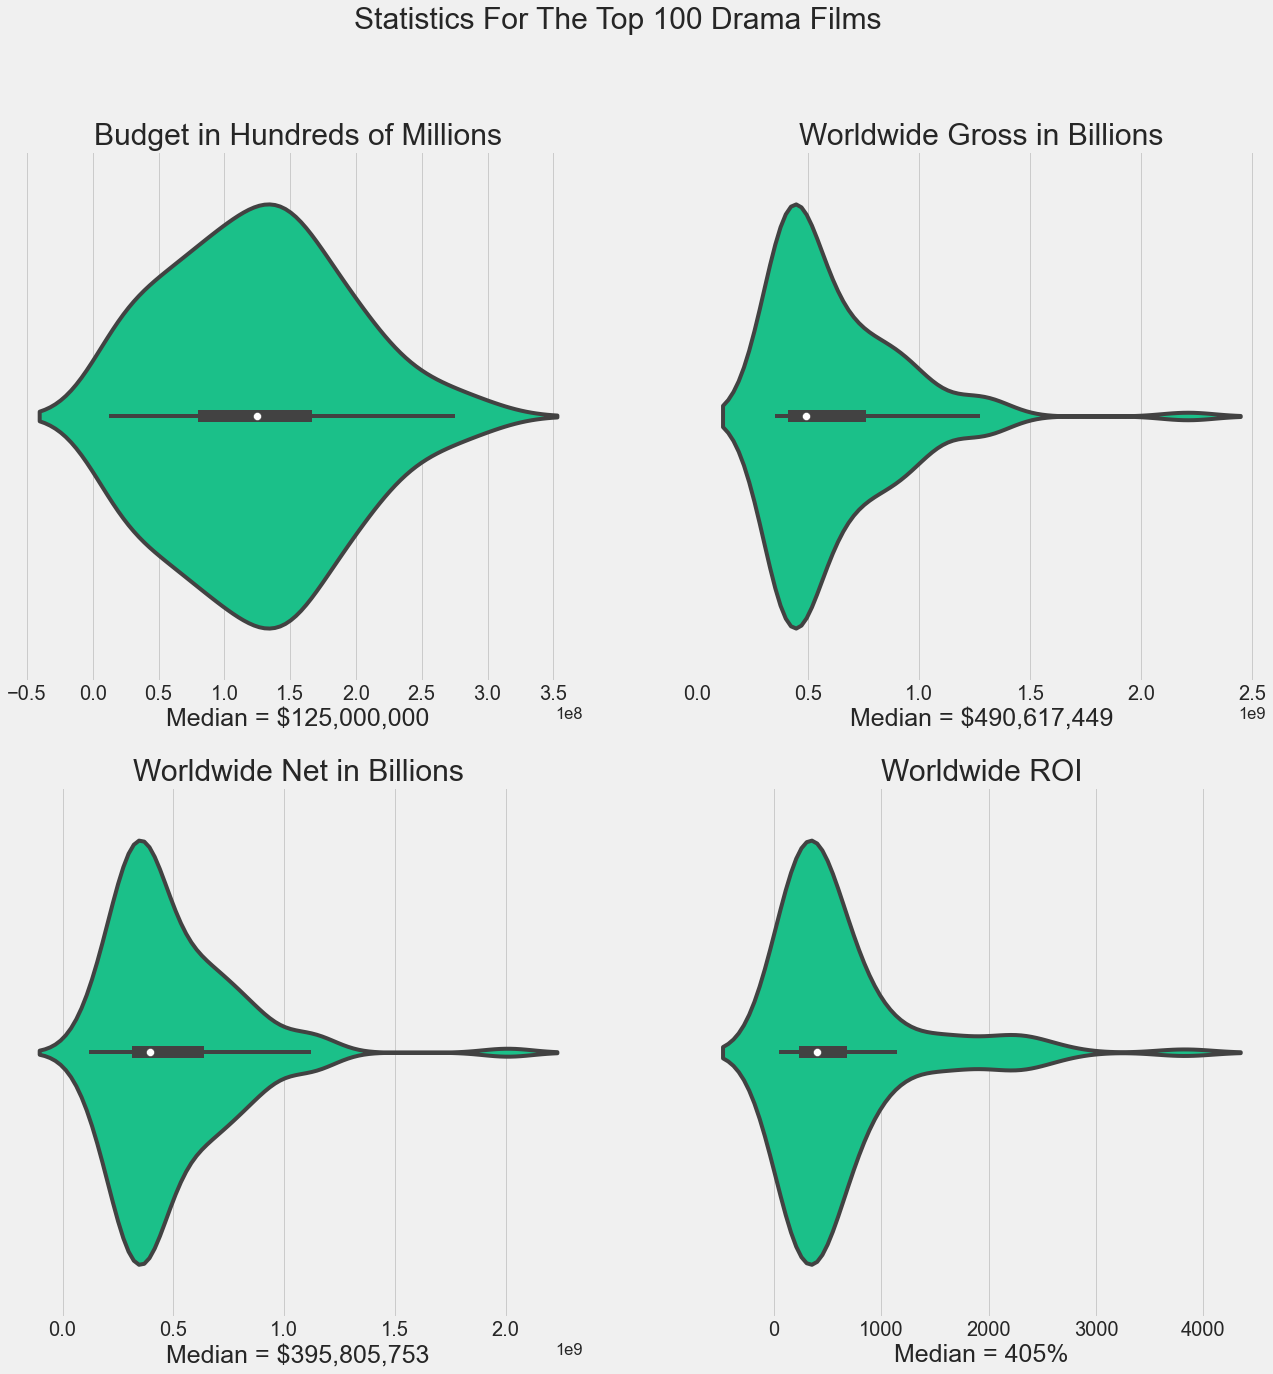

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=drama)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=drama)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=drama)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=drama)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $125,000,000', size=25)
axes[0, 1].set_xlabel('Median = $490,617,449', size=25)
axes[1, 0].set_xlabel('Median = $395,805,753', size=25)
axes[1, 1].set_xlabel('Median = 405%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [52]:
family_df = dfr[(dfr['genres'].str.contains('kids & family', case=False))]
unique_titles_f = family_df.drop_duplicates(subset = ['title'])
top100_family = unique_titles_f.sort_values(by='worldwide_gross', ascending=False).head(100)
family = top100_family[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
family.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2008.470000,1.207530e+08,5.769052e+08,4.561522e+08,491.578233
std,7.280047,5.193093e+07,2.521281e+08,2.416251e+08,441.832129
min,1990.000000,1.500000e+07,2.988152e+08,1.413652e+08,78.011220
25%,2004.000000,7.922500e+07,3.629727e+08,2.676657e+08,234.444177
50%,2010.000000,1.262500e+08,5.111185e+08,4.069029e+08,349.360456
75%,2014.250000,1.512500e+08,7.444216e+08,5.651587e+08,559.336854
max,2019.000000,2.600000e+08,1.272470e+09,1.122470e+09,3077.897833


In [53]:
medians_family = [family.production_budget.median(),\
          family.worldwide_gross.median(),\
          family.worldwide_net.median(),\
          family.worldwide_roi.median()]
medians_family

[126250000.0, 511118519.0, 406902906.0, 349.3604560947713]

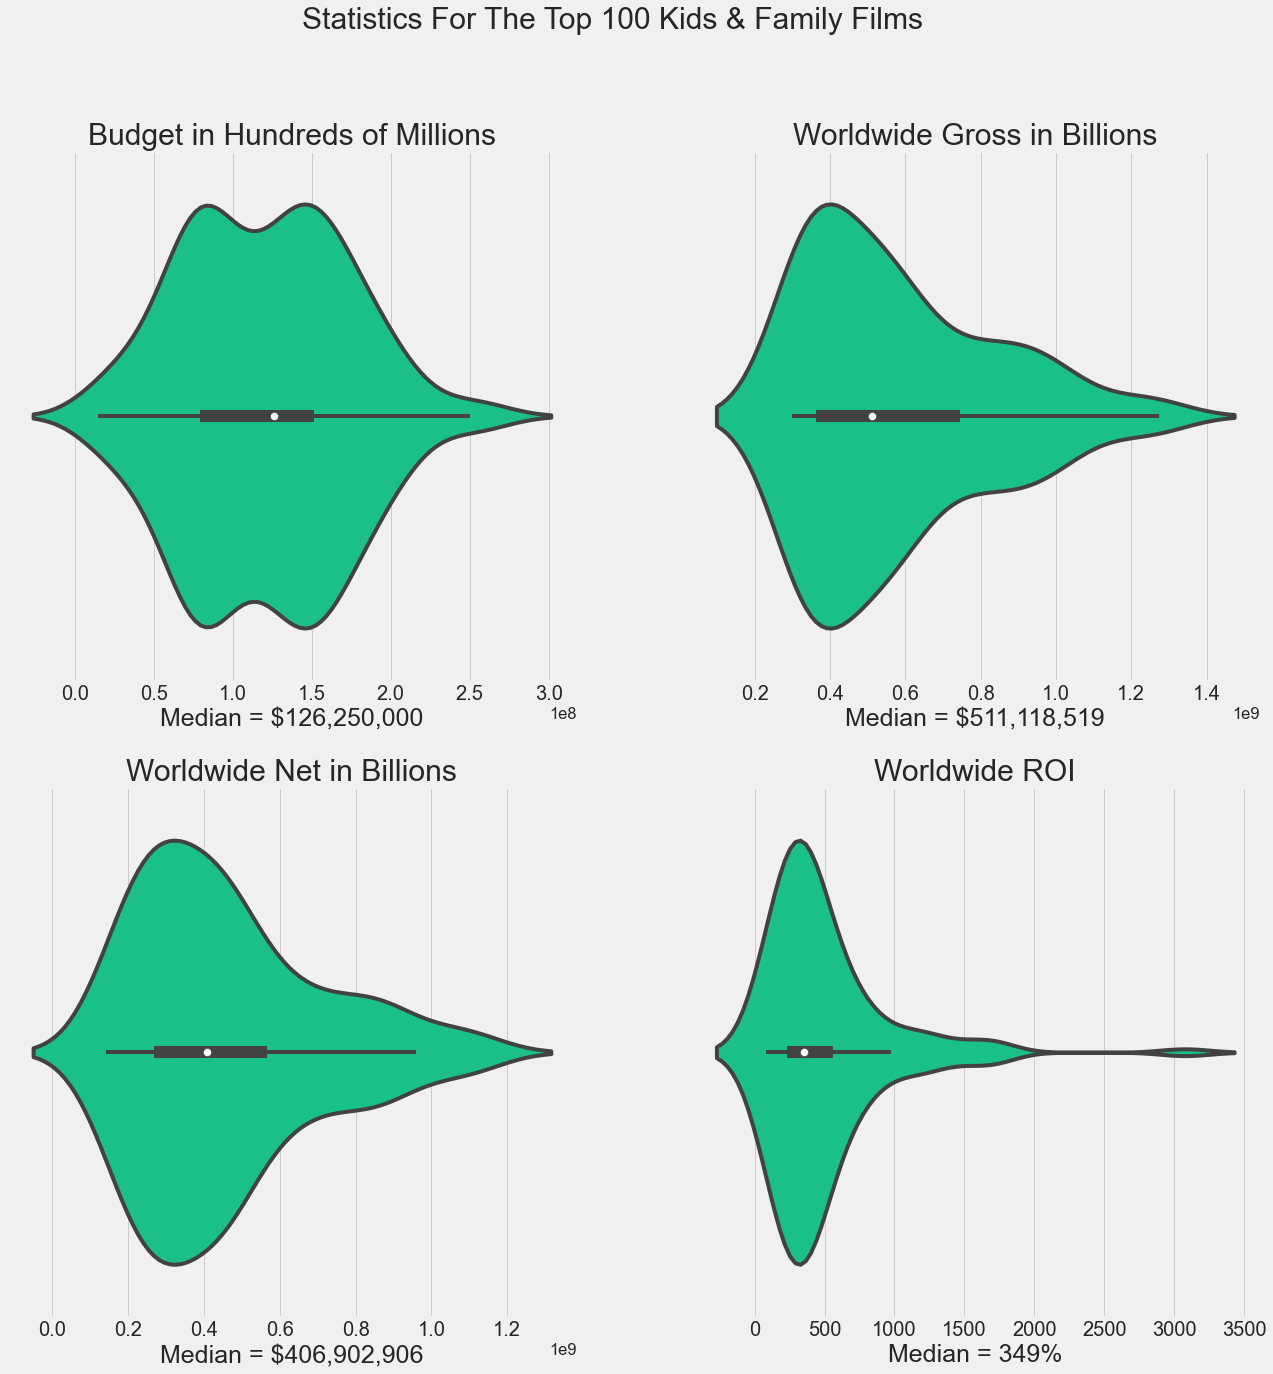

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=family)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=family)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=family)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=family)
fig.suptitle('Statistics For The Top 100 Kids & Family Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $126,250,000', size=25)
axes[0, 1].set_xlabel('Median = $511,118,519', size=25)
axes[1, 0].set_xlabel('Median = $406,902,906', size=25)
axes[1, 1].set_xlabel('Median = 349%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [55]:
animation_df = dfr[(dfr['genres'].str.contains('animation', case=False))]
unique_titles_an = animation_df.drop_duplicates(subset = ['title'])
top100_animation = unique_titles_an.sort_values(by='worldwide_gross', ascending=False).head(100)
animation = top100_animation[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
animation.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2009.080000,1.185366e+08,5.506962e+08,4.321596e+08,736.646455
std,9.363242,4.801282e+07,2.581018e+08,2.480554e+08,3087.037157
min,1942.000000,8.580000e+05,2.507000e+08,1.248064e+08,78.011220
25%,2006.000000,7.750000e+07,3.471274e+08,2.381639e+08,206.803808
50%,2011.000000,1.240000e+08,4.994606e+08,3.755412e+08,339.792843
75%,2015.000000,1.500000e+08,6.411700e+08,5.168098e+08,539.981055
max,2019.000000,2.600000e+08,1.272470e+09,1.122470e+09,31135.431235


In [56]:
medians_animation = [animation.production_budget.median(),\
          animation.worldwide_gross.median(),\
          animation.worldwide_net.median(),\
          animation.worldwide_roi.median()]
medians_animation

[124000000.0, 499460605.5, 375541177.5, 339.7928425416667]

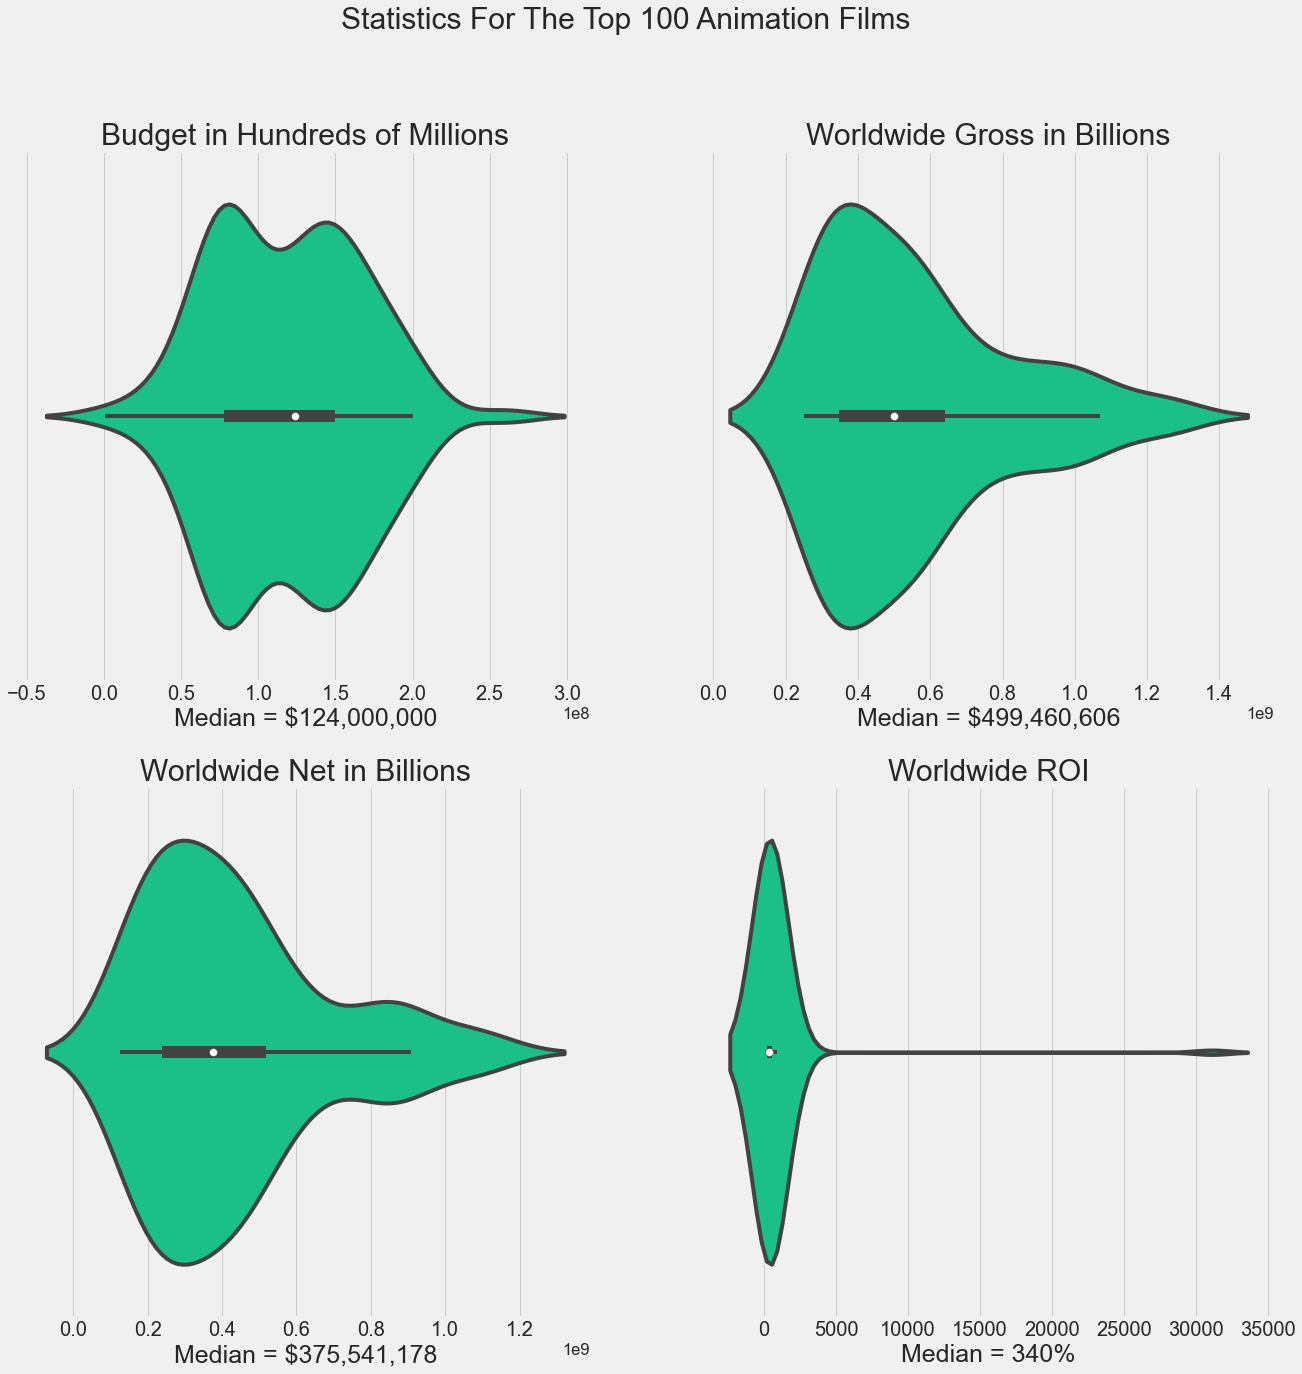

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=animation)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=animation)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=animation)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=animation)
fig.suptitle('Statistics For The Top 100 Animation Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $124,000,000', size=25)
axes[0, 1].set_xlabel('Median = $499,460,606', size=25)
axes[1, 0].set_xlabel('Median = $375,541,178', size=25)
axes[1, 1].set_xlabel('Median = 340%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

## Hidden Value Genres

In [58]:
mystery_df = dfr[(dfr['genres'].str.contains('mystery & suspense', case=False))]
unique_titles_m = mystery_df.drop_duplicates(subset = ['title'])
top100_mystery = unique_titles_m.sort_values(by='worldwide_gross', ascending=False).head(100)
mystery = top100_mystery[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
mystery.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2005.120000,1.009113e+08,4.982518e+08,3.973405e+08,687.026202
std,9.177575,6.754731e+07,3.549953e+08,3.124608e+08,903.767450
min,1975.000000,5.000000e+06,2.398140e+08,8.924622e+07,50.997840
25%,1999.000000,5.937500e+07,3.015452e+08,2.304944e+08,242.336559
50%,2007.000000,9.000000e+07,3.656959e+08,2.996501e+08,344.487165
75%,2012.000000,1.300000e+08,5.550299e+08,4.300212e+08,700.470452
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,5479.296120


In [59]:
medians_mystery = [mystery.production_budget.median(),\
          mystery.worldwide_gross.median(),\
          mystery.worldwide_net.median(),\
          mystery.worldwide_roi.median()]
medians_mystery

[90000000.0, 365695896.0, 299650070.5, 344.48716520408163]

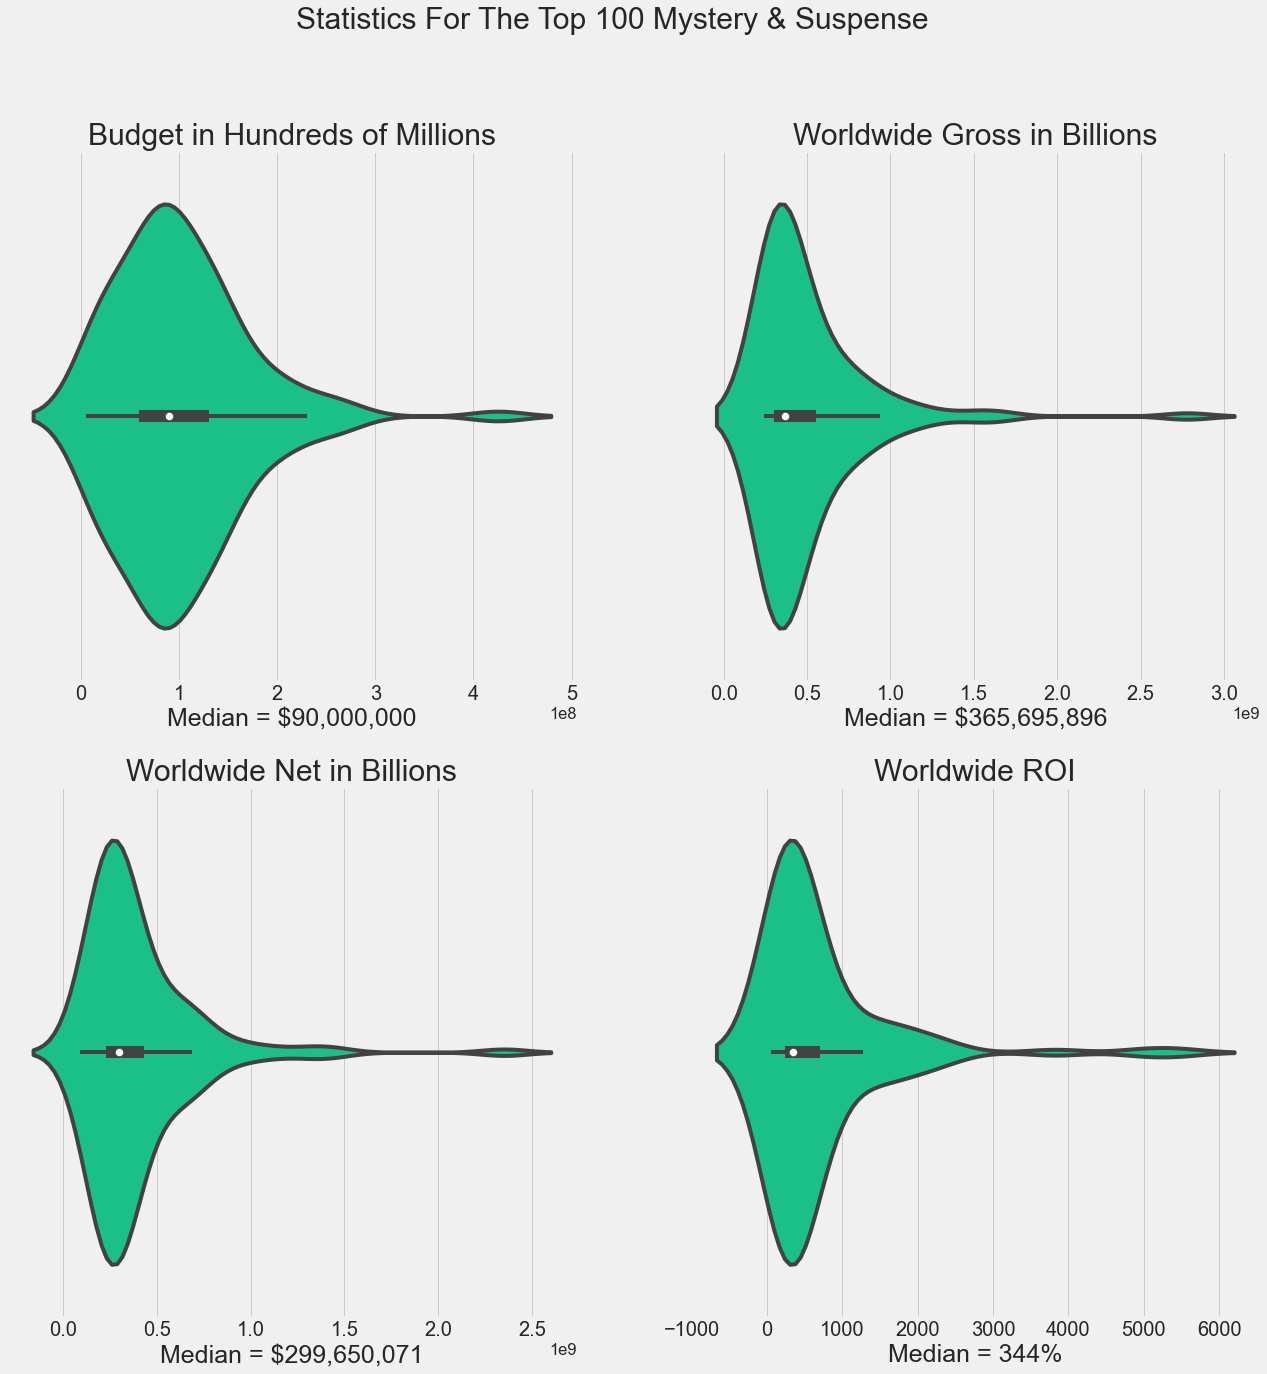

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=mystery)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=mystery)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=mystery)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=mystery)
fig.suptitle('Statistics For The Top 100 Mystery & Suspense', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $90,000,000', size=25)
axes[0, 1].set_xlabel('Median = $365,695,896', size=25)
axes[1, 0].set_xlabel('Median = $299,650,071', size=25)
axes[1, 1].set_xlabel('Median = 344%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [61]:
horror_df = dfr[(dfr['genres'].str.contains('horror', case=False))]
unique_titles_h = horror_df.drop_duplicates(subset = ['title'])
top100_horror = unique_titles_h.sort_values(by='adj_ww_gross', ascending=False).head(100)
horror = top100_horror[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net', 'worldwide_roi']]

horror.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2003.830000,5.472600e+07,2.350136e+08,1.802876e+08,1807.417780
std,11.077373,5.477207e+07,1.789311e+08,1.598030e+08,5996.961903
min,1968.000000,4.500000e+05,3.339543e+07,-1.278725e+07,-10.656041
25%,1999.000000,1.500000e+07,1.360322e+08,9.060174e+07,179.703893
50%,2005.000000,4.000000e+07,1.727050e+08,1.316231e+08,389.850233
75%,2012.000000,7.575000e+07,2.760950e+08,2.276776e+08,1249.850474
max,2019.000000,2.750000e+08,1.272470e+09,1.122470e+09,43051.785333


In [62]:
medians_horror = [horror.production_budget.median(),\
          horror.worldwide_gross.median(),\
          horror.worldwide_net.median(),\
          horror.worldwide_roi.median()]
medians_horror

[40000000.0, 172704982.0, 131623056.0, 389.8502330434783]

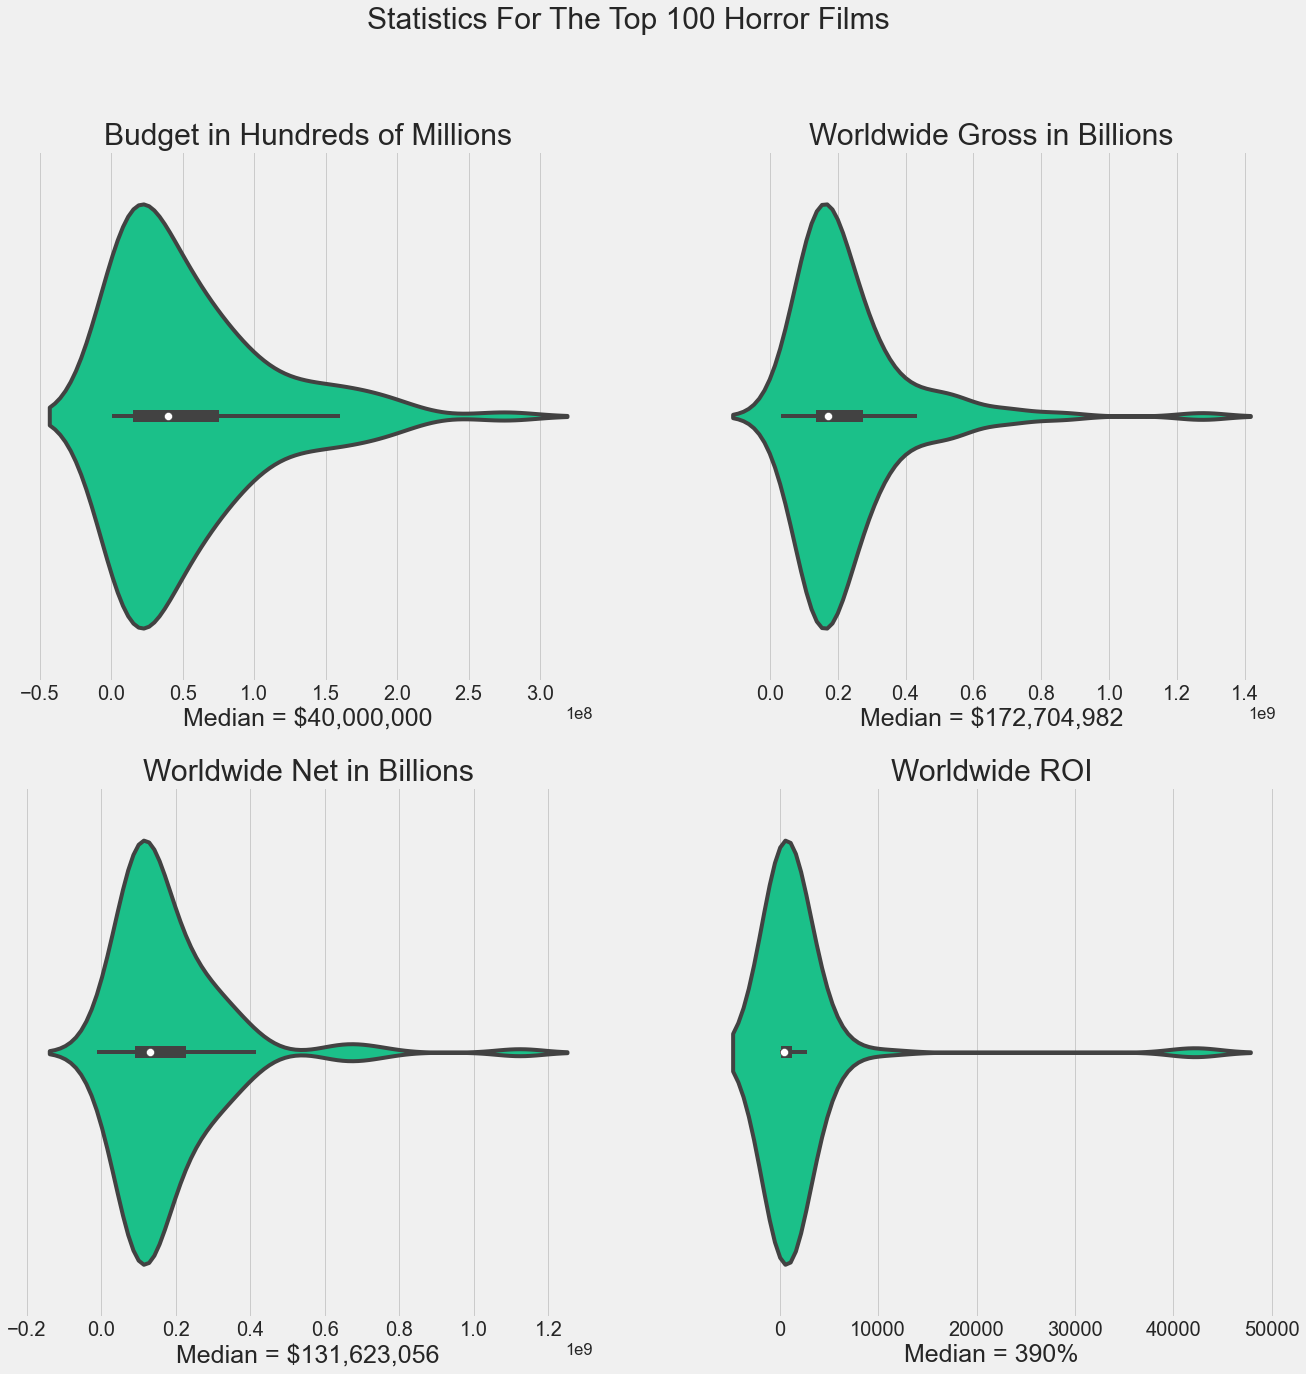

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=horror)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=horror)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=horror)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=horror)
fig.suptitle('Statistics For The Top 100 Horror Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $40,000,000', size=25)
axes[0, 1].set_xlabel('Median = $172,704,982', size=25)
axes[1, 0].set_xlabel('Median = $131,623,056', size=25)
axes[1, 1].set_xlabel('Median = 390%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [64]:
comedy_df = dfr[(dfr['genres'].str.contains('comedy', case=False))]
unique_titles_c = comedy_df.drop_duplicates(subset = ['title'])
top100_comedy = unique_titles_c.sort_values(by='worldwide_gross', ascending=False).head(100)
comedy = top100_comedy[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net', 'worldwide_roi']]
comedy.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2006.780000,1.002610e+08,5.832438e+08,4.829828e+08,842.968449
std,8.392613,7.039659e+07,3.076128e+08,2.718090e+08,1060.783737
min,1978.000000,5.000000e+06,3.320000e+08,1.462710e+08,78.011220
25%,2002.000000,5.500000e+07,3.846356e+08,3.263143e+08,322.866115
50%,2008.000000,8.500000e+07,5.170838e+08,4.231729e+08,515.828420
75%,2013.000000,1.312500e+08,6.285260e+08,5.279421e+08,925.159407
max,2018.000000,4.250000e+08,2.776345e+09,2.351345e+09,7397.800680


In [65]:
medians_comedy = [comedy.production_budget.median(),\
          comedy.worldwide_gross.median(),\
          comedy.worldwide_net.median(),\
          comedy.worldwide_roi.median()]
medians_comedy

[85000000.0, 517083787.5, 423172876.5, 515.8284198677248]

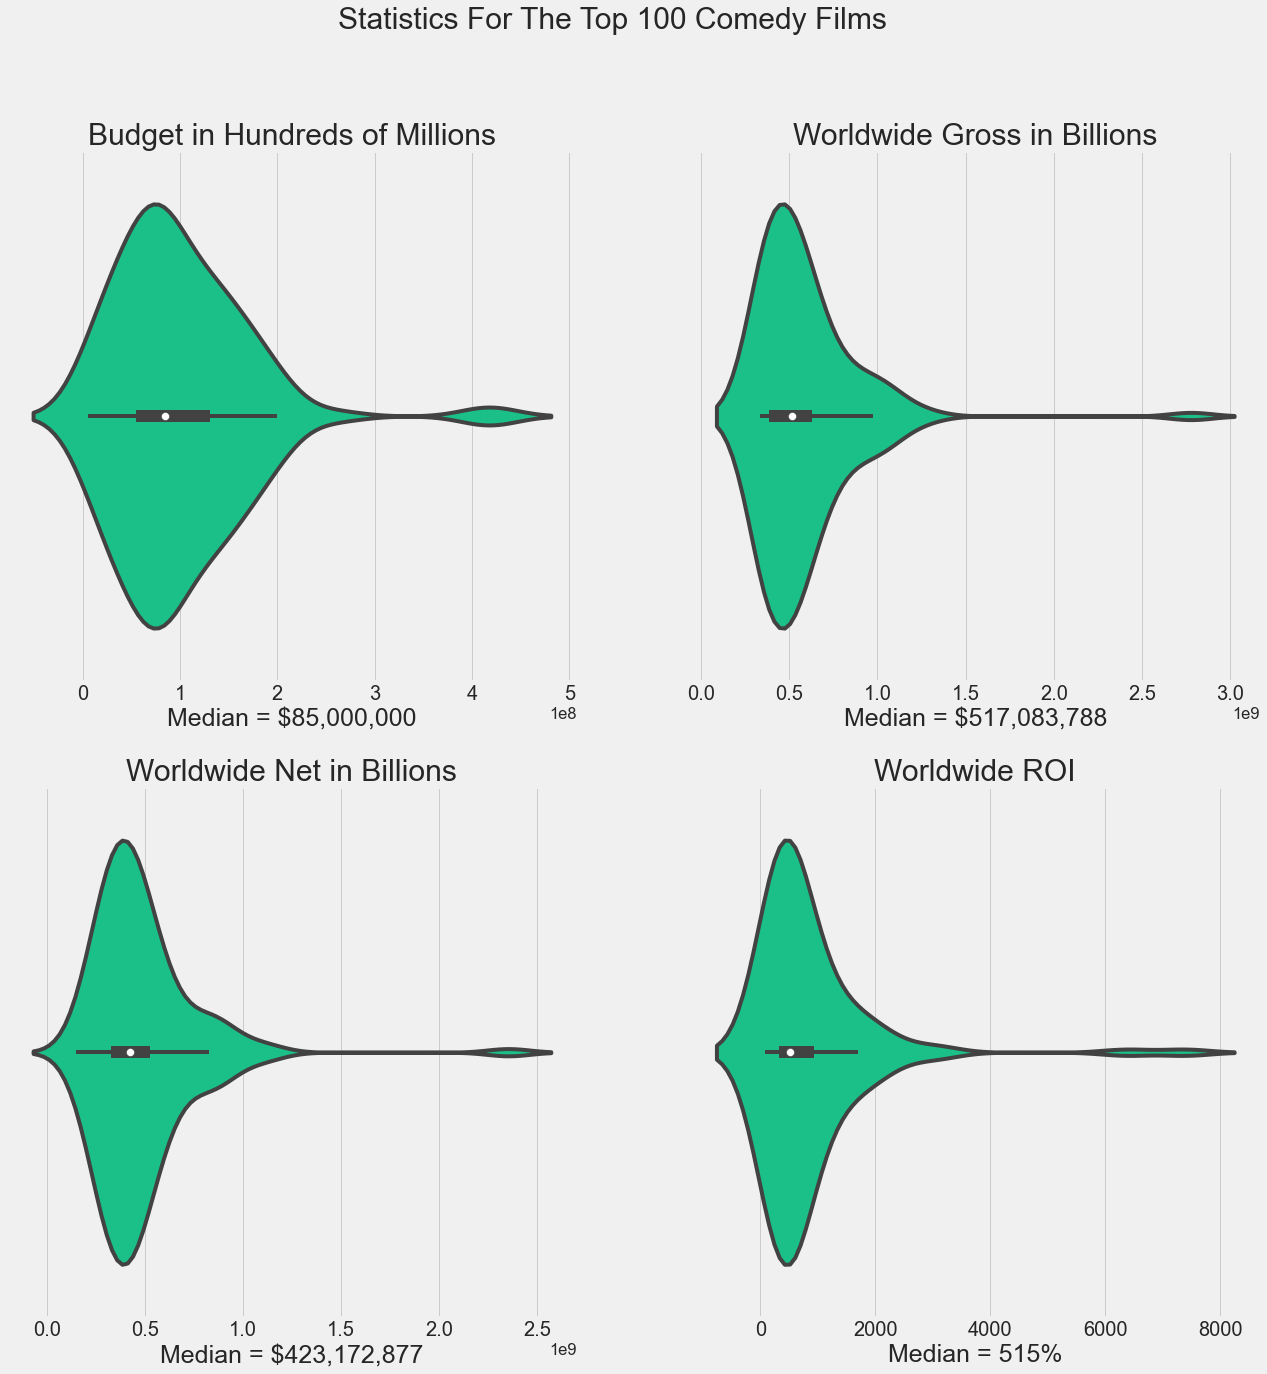

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=comedy)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=comedy)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=comedy)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=comedy)
fig.suptitle('Statistics For The Top 100 Comedy Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 30)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 30)
axes[1, 0].set_title('Worldwide Net in Billions', size = 30)
axes[1, 1].set_title('Worldwide ROI', size = 30)
axes[0, 0].set_xlabel('Median = $85,000,000', size=25)
axes[0, 1].set_xlabel('Median = $517,083,788', size=25)
axes[1, 0].set_xlabel('Median = $423,172,877', size=25)
axes[1, 1].set_xlabel('Median = 515%', size=25)
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

3881250000.0

# Top Creative Talent

In [68]:
#  dropping problematic titles with multiple entries as they are found
dfi = dfi[dfi.title != 'Titanic']
dfi = dfi[dfi.title != 'Cinderella']
dfi = dfi[dfi.title != 'Snow White and the Seven Dwarfs']
dfi = dfi[dfi.title != 'Beauty and the Beast']
dfi = dfi[dfi.title != 'Bambi']
dfi = dfi[dfi.title != 'Avatar']
dfi = dfi[dfi.title != 'Pinocchio']
dfi = dfi[dfi.title != 'Ben-Hur']

In [70]:
# getting column names
dfi.columns

Index(['nconst', 'primary_name', 'tconst', 'category', 'genres', 'date',
       'title', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'adj_prod_budg',
       'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross', 'adj_dom_net',
       'adj_ww_net', 'adj_i_net', 'dom_roi', 'ww_roi', 'i_roi'],
      dtype='object')

# Top 20 Actors By Worldwide Gross

In [71]:
# creating actor dataframe
actor_df = dfi[dfi['category'].str.contains('actor')]

# creating preliminary top 100 actors list
top100_grossing_actors = actor_df.groupby(['primary_name'])\
                                          .worldwide_gross.sum().sort_values(ascending=False).head(100) 
top100_actors = pd.DataFrame(top100_grossing_actors)

# resetting index
reset_idx = top100_actors.reset_index()

# getting name list
actor_list = list(reset_idx.primary_name)

# running imdb actor list against rt movie list to work-around problematic titles.
gross = []
for name in actor_list:
    value = dfr[dfr['actors'].str.contains(name)].worldwide_gross.sum()
    gross.append(value)
    
#  creating new gross dataframe
dict = {'primary_name': actor_list, 'worldwide_gross': gross}
gross_df = pd.DataFrame(dict, index=actor_list)
top50_gross_actors = gross_df.sort_values(by='worldwide_gross', ascending=False).head(50)

# getting movie count
movie_count_m = actor_df.groupby(['primary_name']).title.count()
count_m = pd.DataFrame(movie_count_m)

# joining dfs
joined_m = top50_gross_actors.join(count_m)

# adding mean gross column
joined_m['mean_gross'] = joined_m.worldwide_gross/joined_m.title
joined_m = joined_m.reset_index()
joined_m = joined_m.rename(columns={'primary_name': 'Actor',\
                                       'title': 'Number of Titles', 'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

# sorting top 20 cumulative gross and mean gross films
top20_cuml_gross_actors =  joined_m.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actors = joined_m.sort_values(by='Mean Gross per Title', ascending=False).head(20)

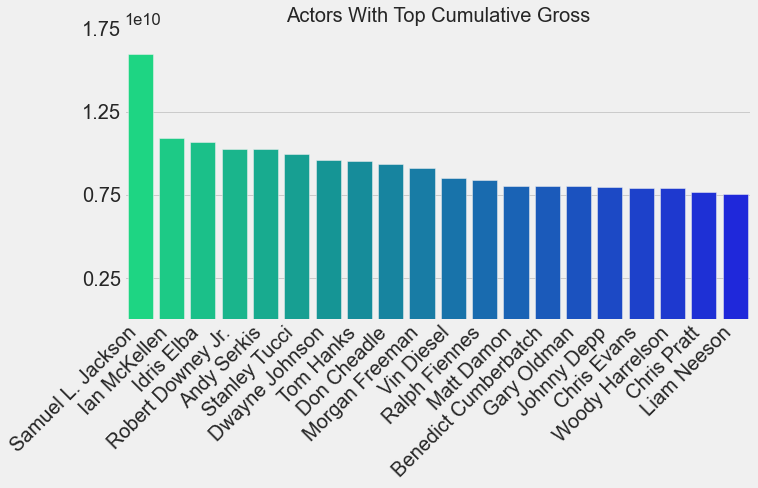

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Cumulative Gross', data=top20_cuml_gross_actors, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .75*10**10, 1.25*10**10, 1.75*10**10])
plt.xticks(rotation=45, ha='right')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Actors With Top Cumulative Gross", fontsize=20)
plt.show()

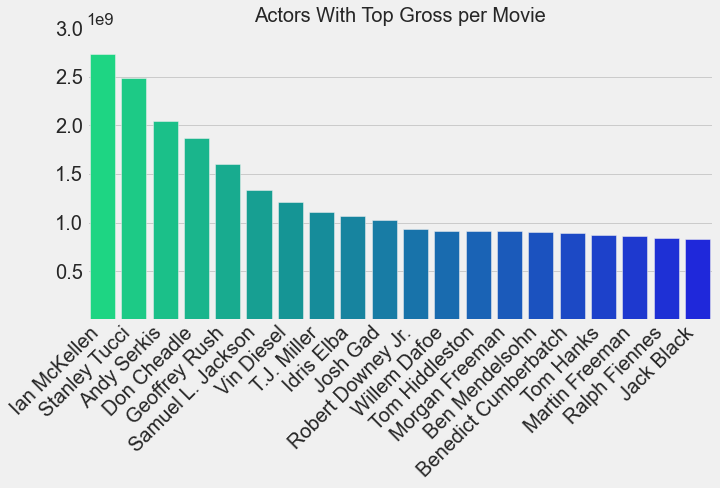

In [82]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross_actors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9, 3.0*10**9])
ax.set_xlabel("") 
ax.set_ylabel("")
ax.set_title("Actors With Top Gross per Movie", fontsize=20) 
plt.show() 

## Actors Top Genres

In [86]:
# finding optimal genre by imdb cumulative gross for each actor in top 100
optimal_genre = []
for actor in actor_list:
    collection = []
    for genre in genres_i:
        gross = actor_df[(actor_df['primary_name'] == actor)\
                         & (actor_df.genres.str.contains(genre, case=False))].worldwide_gross.sum()
        collection.append((actor, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

# creating actor optimal genre dataframe
actor_genre = []
actor_gross = []
for i in range(100):
    actor_genre.append(optimal_genre[i][1])
    actor_gross.append(optimal_genre[i][2])
actor_genre_df = pd.DataFrame()
actor_genre_df['actor'] = actor_list
actor_genre_df['genre'] = actor_genre
actor_genre_df['worldwide_gross'] = actor_gross

In [87]:
# optimal genre by worldwide gross for each actor
ag = actor_genre_df.sort_values(by='worldwide_gross', ascending=False).head(20)
ag[['actor', 'genre']].head()

,actor,genre
0,Robert Downey Jr.,Adventure
2,Chris Evans,Action
1,Dwayne Johnson,Action
3,Chris Hemsworth,Action
7,Vin Diesel,Action


# Top 20 Actors By Worldwide Gross

In [74]:
# creating actress df
actress_df = dfi[dfi['category'].str.contains('actress')]

# initial top 100
top100_grossing_actresses = actress_df.groupby(['primary_name'])\
                                               .worldwide_gross.sum().sort_values(ascending=False).head(100) 
top100_actresses = pd.DataFrame(top100_grossing_actresses)

# resetting index
reset_idx_f = top100_actresses.reset_index()

# getting name list and adding kate winslet
actress_list = list(reset_idx_f.primary_name)[:99]
actress_list.append('Kate Winslet')

# running imdb actress list against rt movie list to work-around problematic titles.
gross_f = []
for name in actress_list:
    value = dfr[dfr['actors'].str.contains(name)].worldwide_gross.sum()
    gross_f.append(value)

#  creating new adj gross dataframe
dict = {'primary_name': actress_list, 'worldwide_gross': gross_f}
gross_df_f = pd.DataFrame(dict, index=actress_list)
top50_gross_actresses = gross_df_f.sort_values(by='worldwide_gross', ascending=False).head(50)

# movie count
movie_count_f = actress_df.groupby(['primary_name']).title.count()
count_f = pd.DataFrame(movie_count_f)

# joining dfs
joined_f = top50_gross_actresses.join(count_f)

# added mean gross column
joined_f['mean_gross'] = joined_f.worldwide_gross/joined_f.title
joined_f = joined_f.reset_index()
joined_f = joined_f.rename(columns={'primary_name': 'Actress',\
                                       'title': 'Number of Titles', 'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

# sorting top 20s
top20_cuml_gross_actresses = joined_f.sort_values\
                            (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actresses = joined_f.sort_values\
                            (by='Mean Gross per Title', ascending=False).head(20)

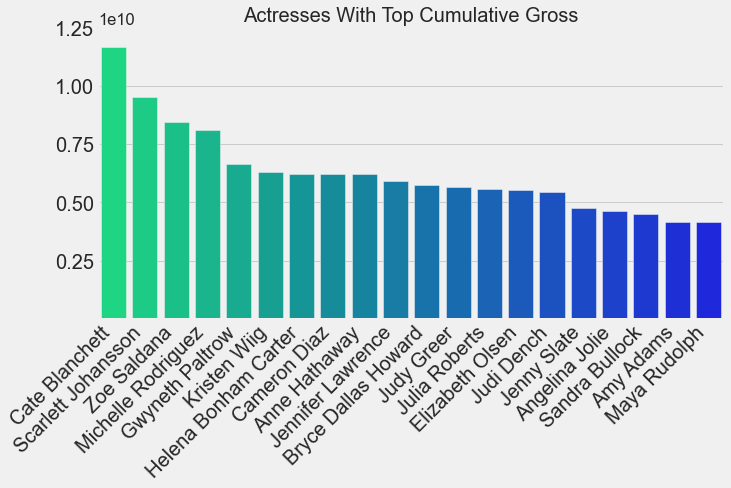

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Cumulative Gross', data=top20_cuml_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .5*10**10, .75*10**10,\
                                  1.0*10**10, 1.25*10**10])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Actresses With Top Cumulative Gross", fontsize=20)
plt.show()

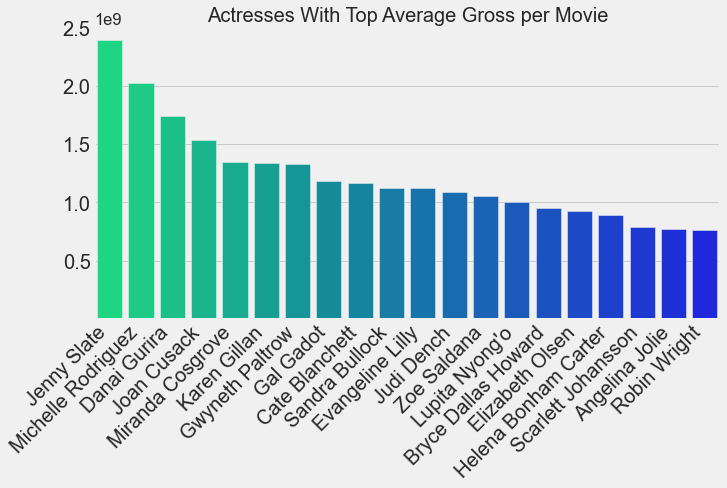

In [84]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Mean Gross per Title',\
            data=top20_mean_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9])
ax.set_xlabel("") 
ax.set_ylabel("")
ax.set_title("Actresses With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Actress Top Genres

In [77]:
# finding optimal genre by adjusted gross
optimal_genre = []
for actress in actress_list:
    collection = []
    for genre in genres_i:
        gross = actress_df[(actress_df['primary_name'] == actress)\
                         & (actress_df.genres.str.contains(genre, case=False))].worldwide_gross.sum()
        collection.append((actress, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

# creating optimal genre dataframe
actress_genre = []
actress_gross = []
for i in range(100):
    actress_genre.append(optimal_genre[i][1])
    actress_gross.append(optimal_genre[i][2])
actress_genre_df = pd.DataFrame()
actress_genre_df['actress'] = actress_list
actress_genre_df['genre'] = actress_genre
actress_genre_df['worldwide_gross'] = actress_gross

In [80]:
# optimal genre for each actress
atsg = actress_genre_df.sort_values(by='worldwide_gross', ascending=False)
atsg[['actress', 'genre']].head()

,actress,genre
0,Jennifer Lawrence,Sci-Fi
1,Scarlett Johansson,Sci-Fi
4,Cate Blanchett,Adventure
3,Kristen Wiig,Comedy
5,Bryce Dallas Howard,Sci-Fi


According to [The Numbers](https://www.the-numbers.com/), each of the top six film companies released an average of 15 films from 2014 to 2019 and the prints & advertising budget for a film was about half the production budget. We'll use these approximations to estimate an initial capital outlay required to produce a year's worth of films.

In [69]:
avg_films_per_year = 15 # big six distributors 
est_inital_prod_costs = avg_films_per_year*top100_gross_films.production_budget.median()
est_marketing_costs = est_inital_prod_costs/2 # rough estimate based on past trends
total_start_costs = est_inital_prod_costs + est_marketing_costs
total_start_costs

3881250000.0

## Conclusions
* Total estimated initial cost for the production and marketing of the first fifteen films: 3,881,250,000 USD.
* The bulk of revenue will come from the international market.
* Action & Adventure, SciFi & Fantasy, Drama, Kids & Family, and Animation are the best bets for maximum gross profits.
* Comedy, Horror and Drama offer the best possiblities for value and ROI.

## Next Steps 

* Look into the prospect of buying a production company rather than starting from scratch.
* Research renting vs building physical production facilities.
* Incorporate the streaming market into the analysis.